### Modelling of 2020 trips and recovery rate (slope)

1. Create a dataset for MSOA vs. Local Authority
2. Predict 2020 trips
3. Decompose recovery by LA/MSOA and calculate slope
4. Create dataset with recovery rate
5. Add features for spatial regression modelling (IMD, working population, Covid at appropriate level). 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
#import io
#import os
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson
#import scipy as sp
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Read in csv data
tubetaps_final = pd.read_csv('output_data/tubetaps_final.csv')
#tfljourneys = pd.read_excel('tfl-journeys-type.xls', sheet_name = 'Journeys')
#coviddeaths = pd.read_csv('2021-04-30_llt_deathrate.csv') # Local Authority, timing is important
#covidrestrictions = pd.read_csv('restrictions_daily.csv') # Global, timing is important
covid_msoa = pd.read_csv('msoa_covidcases_2021-07-12.csv')
jobs = pd.read_csv('jobs_msoa_2011_Census.csv')
imd_msoa = pd.read_csv('imd2019_msoa_level_data.csv')
imd_la = pd.read_csv('Local_Authority_(Lower_Tier)_IMD_2019_(OSGB1936).csv') # Local Authority, no geometry
geolookup = pd.read_csv('2011_OA-LSOA-MSOA-LA.csv')
#clt_msoas = pd.read_csv('clt_msoas.csv')
poi_msoas = pd.read_csv('poi_msoas.csv', encoding= 'unicode_escape')

# Shape Files
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
imd = gpd.read_file('IMD_2019/Indices_of_Multiple_deprivation_(IMD)_2019.shp') #LSOA, smaller than MSOA
clt_msoas = gpd.read_file('clt_msoas.shp')
                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')
imd = imd.to_crs('epsg:27700')
clt_msoas = clt_msoas.to_crs('epsg:27700')

### 01 Data Processing

Create a weekly version of the tubetaps data. Create both at an MSOA and Local Authority level to allow for different levels of modelling.

In [3]:
# Convert columns to datetime

df = tubetaps_final

df['travel_date'] = pd.to_datetime(df['travel_date'])
df['date'] = pd.to_datetime(df['date'])
df['week_beg'] = pd.to_datetime(df['week_beg'])

tubetaps_final = df

In [4]:
# Group by MSOA, and Local Authority, count number of stations. Convert back into geodataframe for IMD join.


# City of London has different number of master_nlc's depending on the day, there are a different number of stations per day
# likely based on what is operational. This will need to be averaged at higher levels of aggergation.


rail_msoa = tubetaps_final.groupby(['year',
                                     'month',
                                     'week',
                                     'week_beg',
                                     'weekday',
                                     'day',
                                     'travel_date',
                                     'date',
                                     'MSOA11CD',
                                     'MSOA11NM']).agg({'origin_trips':'sum',
                                                     'destination_trips': 'sum',
                                                     'master_nlc': 'count'}).reset_index()

rail_msoa = rail_msoa.merge(msoas, left_on = ['MSOA11CD','MSOA11NM'] , right_on = ['MSOA11CD','MSOA11NM'])
rail_msoa = rail_msoa[['year','month','week','week_beg','weekday','day','travel_date','date','MSOA11CD','MSOA11NM', 'geometry','origin_trips', 'destination_trips', 'master_nlc']]
rail_msoa = gpd.GeoDataFrame(rail_msoa, crs = 'epsg:27700')

rail_la = tubetaps_final.groupby(['year',
                                  'month',
                                  'week',
                                  'week_beg',
                                  'weekday',
                                  'day',
                                  'travel_date',
                                  'date',
                                  'LAD11CD',
                                  'LAD11NM']).agg({'origin_trips':'sum',
                                                   'destination_trips': 'sum',
                                                   'master_nlc': 'count'}).reset_index()

rail_la = rail_la.merge(boroughs, left_on = 'LAD11CD', right_on = 'GSS_CODE')
rail_la = rail_la[['year','month','week','week_beg','weekday','day', 'travel_date','date','LAD11CD','LAD11NM', 'origin_trips', 'destination_trips', 'master_nlc']]

In [5]:
# Create indicators for weekday and log the dependent variable as we know we'll need it later.
# Weekday Indicator

#indicator = {'Monday': 'weekday', 'Tuesday': 'weekday', 'Wednesday':'weekday', 'Thursday': 'weekday', 'Friday': 'weekday', 'Saturday':'weekend', 'Sunday':'weekend'}
#rail_msoa['weekend_indicator'] = 0
#rail_msoa['weekend_indicator'] = rail_msoa['weekday'].map(indicator)
#rail_la['weekend_indicator'] = 0
#rail_la['weekend_indicator'] = rail_la['weekday'].map(indicator)

# Log dependent variables
rail_msoa['log_origin_trips'] = np.log(rail_msoa['origin_trips'])
rail_msoa['log_destination_trips'] = np.log(rail_msoa['destination_trips'])
rail_la['log_origin_trips'] = np.log(rail_la['origin_trips'])
rail_la['log_destination_trips'] = np.log(rail_la['destination_trips'])

In [6]:
# Rename columns

rail_msoa = rail_msoa.rename({'MSOA11NM':'msoa_name',
                              'MSOA11CD':'msoa_code',
                              'master_nlc':'number_tubestations'}, axis = 1)

rail_la = rail_la.rename({'LAD11NM':'la_name',
                          'LAD11CD':'la_code',
                          'master_nlc':'number_tubestations'}, axis = 1)


In [7]:
## Preparing dataframe to be a Time Series dataframe

# First need to create an index that is datetime

rail_msoa = rail_msoa.set_index('travel_date')
rail_la = rail_la.set_index('travel_date')

In [8]:
# Checking for NaNs

df = rail_la
is_NaN =df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN
print(rows_with_NaN['origin_trips'].agg('sum') + rows_with_NaN['destination_trips'].agg('sum'))

0.0


In [9]:
# Create a weekly time series for la/msoa

df = rail_msoa


df = df.reset_index()
df = df.groupby(['year', 'week', 'week_beg', 'msoa_code', 'msoa_name']).agg({'origin_trips': 'sum',
                                                                             'destination_trips': 'sum',
                                                                             'number_tubestations': 'mean'})
df = df.reset_index()
df['log_origin_trips'] = np.log(df['origin_trips'])
df['log_destination_trips'] = np.log(df['destination_trips'])

df = df.merge(msoas, left_on = ['msoa_code','msoa_name'] , right_on = ['MSOA11CD','MSOA11NM'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df[['year', 'week','week_beg','msoa_code','msoa_name','geometry','number_tubestations','origin_trips','destination_trips','log_origin_trips','log_destination_trips']]
#df = df.rename({'travel_date':'week_beg'}, axis = 1)

rail_msoawk = df


df = rail_la

df = df.reset_index()
df = df.groupby(['year', 'week', 'week_beg', 'la_code', 'la_name']).agg({'origin_trips': 'sum',
                                                                         'destination_trips': 'sum',
                                                                        'number_tubestations': 'mean'})
df = df.reset_index()
df['log_origin_trips'] = np.log(df['origin_trips'])
df['log_destination_trips'] = np.log(df['destination_trips'])

df = df.merge(msoas, left_on = ['la_code','la_name'] , right_on = ['LAD11CD','LAD11NM'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df[['year','week','week_beg','la_code','la_name','geometry','number_tubestations','origin_trips','destination_trips','log_origin_trips','log_destination_trips']]
df = df.rename({'travel_date':'week_beg'}, axis = 1)

rail_lawk = df

### Time Series Model


Exploratory Analysis of Time Series Data: trend, boxplot, validate autocorrelation.

1. Plot the trend, which looks fairly stable till 2020
2. Boxplots of annual and monthly data to see trends and seasonality
2.1. With these trends, we can determine that the data is dependent on time, and we want a stationary dataset
2.2. Ensuring the dataset is stationary removes autocorrelation -- we need to include a lag to do so. 
3. Therefore, we test for stationarity and build features to support stationarity if needed.
4. Data must be detrended and deseasonalised

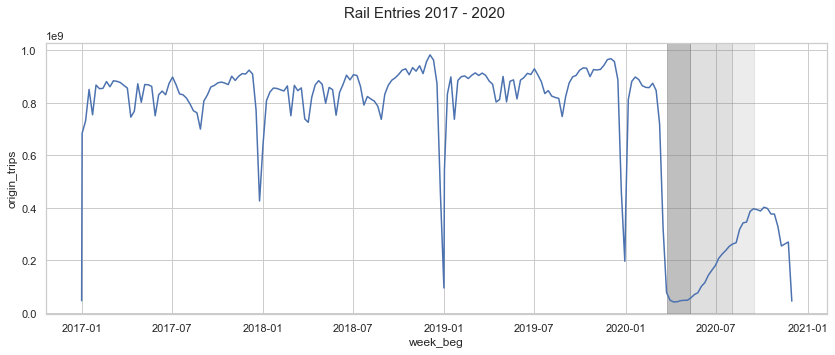

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharex=False, sharey=False)
fig.suptitle('Rail Entries 2017 - 2020', fontsize=15)
df = rail_lawk

df = df[df['week_beg']>='01/01/2017']
df = df.groupby(['week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df).reset_index()
sns.lineplot(data = df, x = "week_beg", y = "origin_trips", ci = None)
ax.axvspan(date2num(datetime(2020,3,24)), date2num(datetime(2020,5,10)), color="grey", alpha=0.50)
ax.axvspan(date2num(datetime(2020,5,10)), date2num(datetime(2020,8,1)), color="grey", alpha=0.25)
ax.axvspan(date2num(datetime(2020,8,1)), date2num(datetime(2020,9,14)), color="grey", alpha=0.15)

In [11]:
# Add table for percent increase in total trips, provide a distribution.

Text(0.5, 1.0, 'Boxplot: Annual Origin Trips 2017 - 2019')

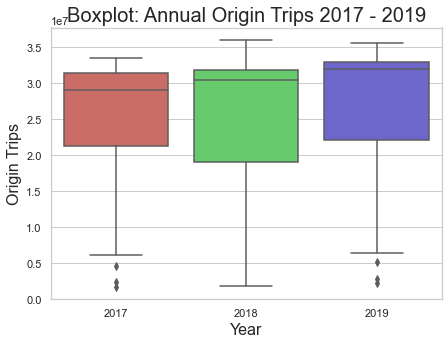

In [12]:
f,ax = plt.subplots(1, 1, figsize = (7,5))

df = rail_la[(rail_la['week_beg']>='01/01/2017')&(rail_la['week_beg']<='12/31/2019')]
df = df.groupby(['month','year', 'week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df).reset_index()

p = sns.boxplot(x='year', y='origin_trips', data = df, palette = 'hls', ax = ax)

p.set_xlabel("Year", fontsize = 16)
p.set_ylabel("Origin Trips", fontsize = 16)
p.set_title("Boxplot: Annual Origin Trips 2017 - 2019", fontsize = 20)

Text(0.5, 1.0, 'Boxplot: Annual Origin Trips 2017 - 2019')

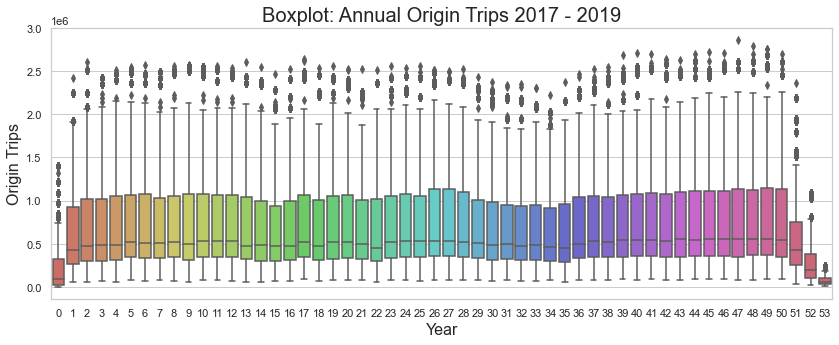

In [13]:
# Boxplot gives a sense of the distribution, showing that median is fairly consistent with the exception of weeks 0 and 51-53.
f,ax = plt.subplots(1, 1, figsize = (14,5))

df = rail_lawk

df = df[(df['week_beg']>='01/01/2017')&(df['week_beg']<='12/31/2019')&(df['la_name']!='Westminster')]
#df = df.groupby(['year', 'week'])['origin_trips'].agg('sum')
#df = pd.DataFrame(df).reset_index()

p = sns.boxplot(x='week', y='origin_trips', data = df, palette = 'hls', ax = ax)

p.set_xlabel("Year", fontsize = 16)
p.set_ylabel("Origin Trips", fontsize = 16)
p.set_title("Boxplot: Annual Origin Trips 2017 - 2019", fontsize = 20)

Text(0.5, 1.0, 'Lineplot: Weekly Origin Trips 2017-2019')

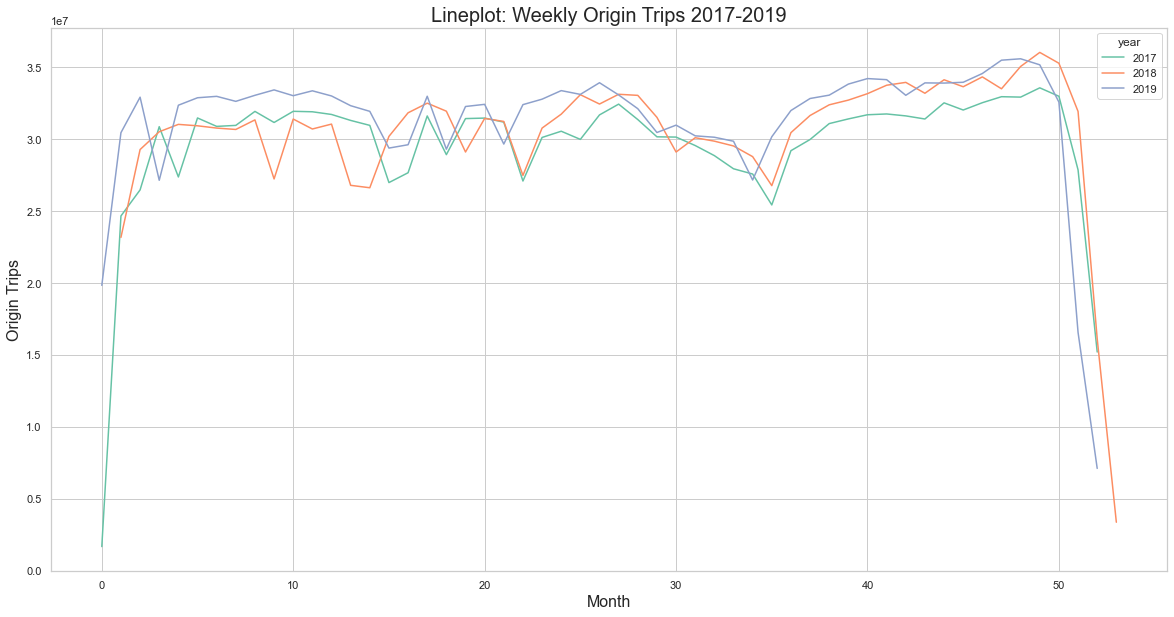

In [14]:
# We can also examine the trend, where 2019 appears smoother than previous years, although has a sharper drop in the
# beginning of the year. This is important when considering predicting 2020, what should the shape look like?

f,ax = plt.subplots(1, 1, figsize = (20,10))

df = rail_la[(rail_la['date']>='01/01/2017')&(rail_la['date']<='12/31/2019')]
df = df.groupby(['month','year', 'travel_date'])['origin_trips'].agg('sum')
df = pd.DataFrame(df).reset_index()

#df2 = rail_la[(rail_la['date']>='01/01/2019')&(rail_la['date']<='12/31/2019')]
#df2 = df2.groupby(['month','year', 'travel_date'])['origin_trips'].agg('sum')
#df2 = pd.DataFrame(df2).reset_index()

df2 = rail_la[(rail_la['date']>='01/01/2017')&(rail_la['date']<='12/31/2019')]
df2 = df2.groupby(['year','week'])['origin_trips'].agg('sum')
df2 = pd.DataFrame(df2).reset_index()

#p = sns.boxplot(x='year', y='origin_trips', data = df, palette = 'Set2', ax = ax[0])
q = sns.lineplot(x='week', y='origin_trips', data = df2, palette = 'Set2', hue = 'year', ax = ax)#[0])
#q = sns.boxplot(x='month', y = 'origin_trips', data = df2, palette = 'hls', ax = ax[1])

#p.set_xlabel("Year", fontsize = 16)
#p.set_ylabel("Origin Trips", fontsize = 16)
#p.set_title("Boxplot: Annual Origin Trips 2017 - 2019", fontsize = 20)

q.set_xlabel("Month", fontsize = 16)
q.set_ylabel("Origin Trips", fontsize = 16)
q.set_title("Lineplot: Weekly Origin Trips 2017-2019", fontsize = 20)

Text(0.5, 1.0, '2019 Total Daily Entries by Local Authority')

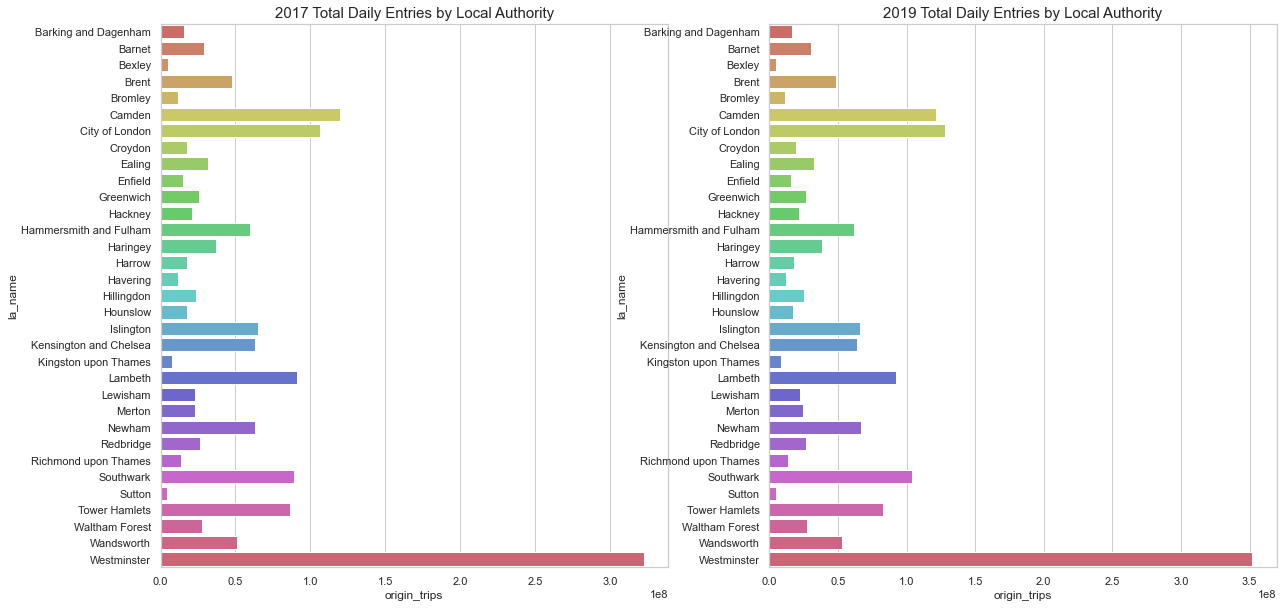

In [15]:
# By LA, how has distribution changed? We can see that in 2019, City of London overtook Camden. Westminster is an 
# extreme case but cannot simply be treated as an outlier given the volume of trips it contributes.

f,ax = plt.subplots(1, 2, figsize = (20,10))

# Dataframe for Line plot
df = rail_la.reset_index()
df = df[(df['travel_date']>='01/01/2017')&(df['travel_date']<='12/31/2017')].groupby(['la_name'])['origin_trips'].agg('sum')
df = pd.DataFrame(df)
df = df.reset_index()

# Dataframe for % distribution of trips by weekday
df2 = rail_la.reset_index()
df2 = df2[(df2['travel_date']>='01/01/2019')&(df2['travel_date']<='12/31/2019')].groupby(['la_name'])['origin_trips'].agg('sum')
df2 = pd.DataFrame(df2)
df2 = df2.reset_index()


sns.barplot(data = df, x = "origin_trips", y = "la_name", palette = 'hls', ax=ax[0])
sns.barplot(data = df2, x = "origin_trips", y = "la_name", palette = 'hls', ax=ax[1])#, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

ax[0].set_title('2017 Total Daily Entries by Local Authority', fontsize = 15)
ax[1].set_title('2019 Total Daily Entries by Local Authority', fontsize = 15)


Text(0.5, 1.0, 'Logged Daily Entries 2017 - 2019')

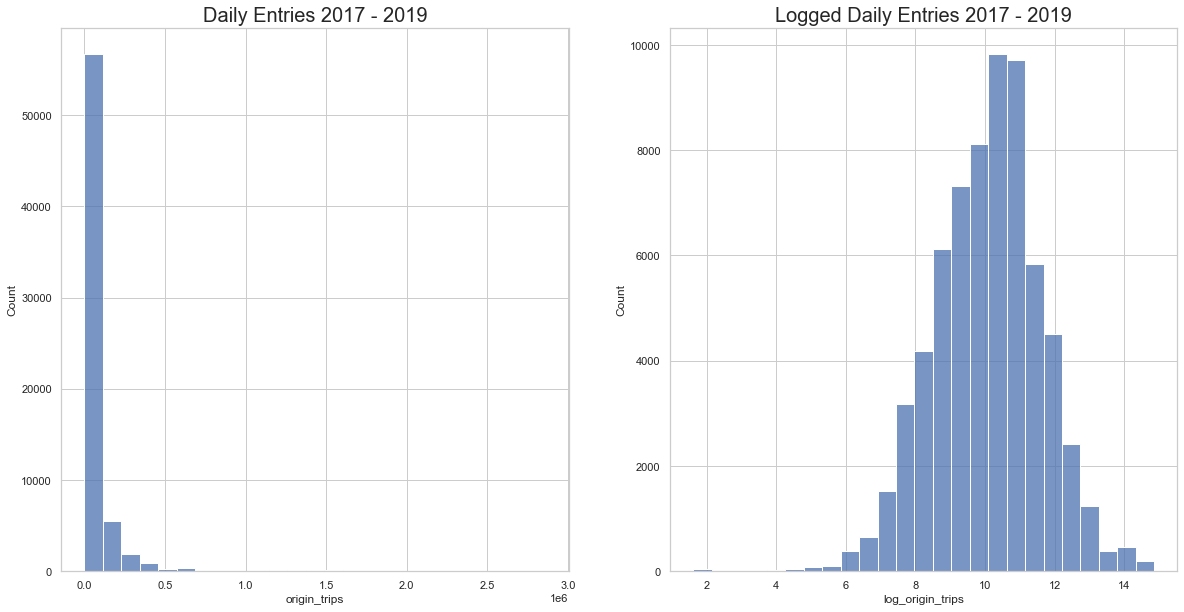

In [16]:
# Histogram of origin_trips, clearly we need to log transform the trips.

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

df = rail_msoawk

df = df.reset_index() #msoa appears to have a more normal distribution, important to highlight
df = df[(df['week_beg']>='01/01/2017')&(df['week_beg']<='12/31/2019')]

p = sns.histplot(data=df, x='origin_trips', bins = 25, ax=ax[0])
q = sns.histplot(data=df, x='log_origin_trips', bins = 25, ax=ax[1])
p.set_title("Daily Entries 2017 - 2019", fontsize = 20)
q.set_title("Logged Daily Entries 2017 - 2019", fontsize = 20)

In [17]:
# Conduct a Dickey Fuller (Unit Root) test for stationarity to prove what we are seeing visually.
# Null hypothesis is that the time series is non-stationary
# P-value is less than .05, and the null hypothesis is rejected. Therefore, this data is stationary..
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

#df = rail_la[(rail_la['date']>='01/01/2017')&(rail_la['date']<='12/31/2019')]
df = rail_msoawk
df = df[(df['week_beg']>='01/01/2017')&(df['week_beg']<='12/31/2019')]

result = adfuller(df['log_origin_trips'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'  {key}, {value}')

ADF Statistic: -13.854386514815454
p-value: 6.910757593012759e-26
Critical Values:
  1%, -3.4304486209193543
Critical Values:
  5%, -2.861583588657227
Critical Values:
  10%, -2.566793200759488


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


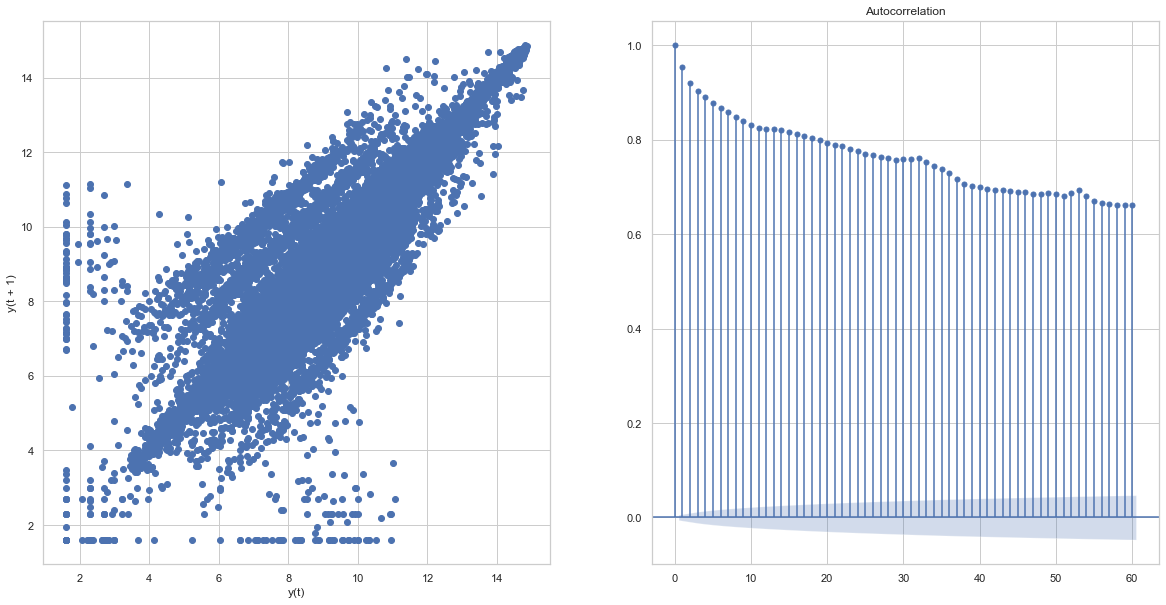

In [18]:
# Checking for autocorrelation
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
df = rail_msoawk

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)
#ax[0]
pd.plotting.lag_plot(df['log_origin_trips'], ax=ax[0])
plot_acf(df['log_origin_trips'], lags = 60, ax=ax[1]);

### Modelling Time Series

In [19]:
# Check for forecast accuracy
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Durbin Watson Statistic for serial correlation of errors of model
# https://www.machinelearningplus.com/vector-autoregression-examples-python/

#df = rail_ts_la[(rail_ts_la['travel_date']>='01/01/2017')&(rail_ts_la['travel_date']<='12/30/2019')]

#res = df['residuals']**2
#RMSE = round(sqrt(res.mean()), 3)
#MAPE = np.mean(np.abs(df['residuals'])/np.abs(df['origin_trips']))
#out = durbin_watson(model_la.resid)

#d = {'Forecast Test':['R-Squared','RMSE', 'MAPE', 'Durbin-Watson'], 'Value':[0.886, RMSE, MAPE, out]}
#df = pd.DataFrame(d)
#df

NameError: name 'rail_ts_la' is not defined

In [20]:
#trips_2017 = rail_ts_la[(rail_ts_la['travel_date']>='01/01/2017')&(rail_ts_la['travel_date']<='11/30/2017')]['origin_trips'].agg('sum')
#trips_2018 = rail_ts_la[(rail_ts_la['travel_date']>='01/01/2018')&(rail_ts_la['travel_date']<='11/30/2018')]['origin_trips'].agg('sum')
#trips_2019 = rail_ts_la[(rail_ts_la['travel_date']>='01/01/2019')&(rail_ts_la['travel_date']<='11/30/2019')]['origin_trips'].agg('sum')
#trips_2020 = rail_ts_la[(rail_ts_la['travel_date']>='01/01/2020')&(rail_ts_la['travel_date']<='11/30/2020')]['origin_trips'].agg('sum')
#trips_est_2020 = rail_test_la[(rail_test_la['travel_date']>='01/01/2020')&(rail_test_la['travel_date']<='11/30/2020')]['estimate2'].agg('sum')

#d = {'Trips Jan - Nov':[2017, 2018, 2019, '2020 Forecast', '2020 Actual'], 'Value':[trips_2017,trips_2018, trips_2019, trips_est_2020, trips_2020]}
#df = pd.DataFrame(d)
#df

In [21]:
# Create a 2020 estimate based on 2019

# Limit Rail to 2019
df = rail_msoawk
df = df[(df['week_beg']>='12/01/2018')&(df['week_beg']<='11/30/2019')]
df_train = df[['week', 'msoa_name', 'log_origin_trips']]
df_train = df_train.rename({'log_origin_trips':'estimate_log_origin'}, axis = 1)

# Establish 2020 estimate
df = rail_msoawk
df = df[(df['week_beg']>='12/01/2019')]
df = df.merge(df_train, left_on = ['week', 'msoa_name'], right_on = ['week', 'msoa_name'])
df['estimate_origin'] = np.exp(df['estimate_log_origin'])
df_estimate = df[['year','week', 'msoa_code', 'estimate_log_origin', 'estimate_origin']]

# merge back to original dataset
df = rail_msoawk
df = df.merge(df_estimate, how = 'left', left_on = ['year', 'week', 'msoa_code'], right_on = ['year','week', 'msoa_code'])
df['estimate_log_origin'] = df['estimate_log_origin'].fillna(0)
df['estimate_origin'] = df['estimate_origin'].fillna(0)
# only pull rows that are not zero as this will drive infinities
df = df[df['estimate_origin']!=0]
df['residuals'] = df['estimate_origin'] - df['origin_trips']

rail_msoaest = df

Text(0.5, 1.0, 'Observed Daily Entries vs. Forecast 2019 - 2020')

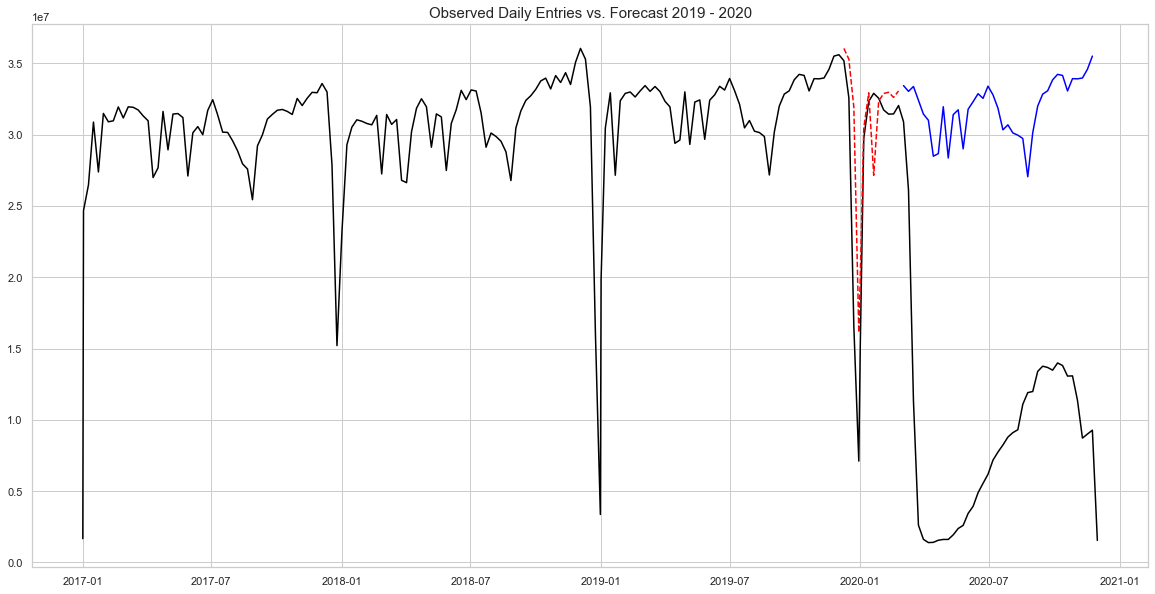

In [38]:
df = rail_msoawk
df2 = rail_msoaest
df3 = rail_msoaest

df = df[df['week_beg']>='01/01/2017'].groupby(['week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df)
df = df.reset_index()

df2 = df2[(df2['week_beg']>='12/01/2019')&(df2['week_beg']<='02/29/2020')].groupby(['week_beg'])['estimate_origin'].agg('sum')
df2 = pd.DataFrame(df2)
df2 = df2.reset_index()

df3 = df3[df3['week_beg']>='02/29/2020'].groupby(['week_beg'])['estimate_origin'].agg('sum')
df3 = pd.DataFrame(df3)
df3 = df3.reset_index()


fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=False, sharey=False)
plt.plot(df.week_beg, df.origin_trips, color = 'black')
plt.plot(df2.week_beg, df2.estimate_origin, color = 'red', ls='--')
plt.plot(df3.week_beg, df3.estimate_origin, color = 'blue')
ax.set_title('Observed Daily Entries vs. Forecast 2019 - 2020', fontsize = 15)

(0.0, 600.0)

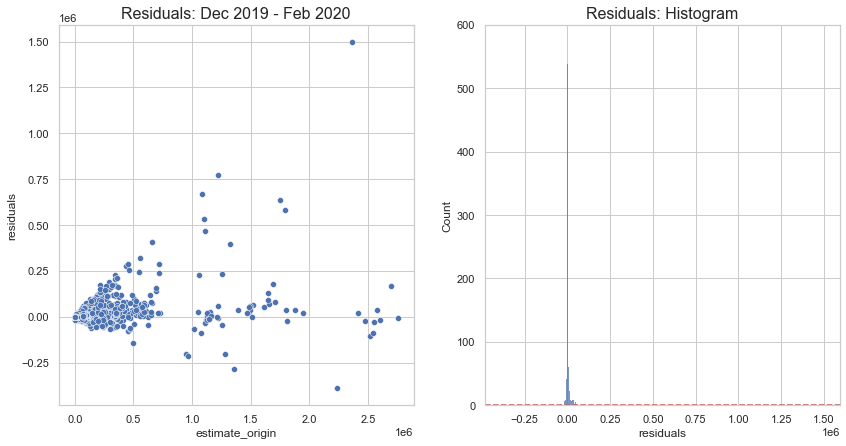

In [105]:
# Plotting of residuals against existing model, not forecasted values.
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

df = rail_msoaest
df = df[(df['week_beg']>='12/01/2019')&(df['week_beg']<='02/29/2020')]

sns.scatterplot(x = "estimate_origin", y = "residuals", data = df, ax=ax[0])
plt.axhline(y=0, color='r', ls='--')

sns.histplot(data=df, x='residuals')
ax[0].set_title('Residuals: Dec 2019 - Feb 2020', fontsize = 16)
ax[1].set_title('Residuals: Histogram', fontsize = 16)
ax[1].set_ylim(0,600)
#ax[1].set_xlim(-500000,500000)

In [108]:
# Check for forecast accuracy
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Durbin Watson Statistic for serial correlation of errors of model
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Calculate r-squared
# https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python

df = rail_msoaest
df = df[(df['week_beg']>='12/01/2019')&(df['week_beg']<='02/29/2020')]

correlation_matrix = np.corrcoef(df['estimate_origin'], df['origin_trips'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2


res = df['residuals']**2
RMSE = round(sqrt(res.mean()), 3)
MAPE = np.mean(np.abs(df['residuals'])/np.abs(df['origin_trips']))
out = durbin_watson(df['residuals'])

d = {'Forecast Test':['R-Squared','RMSE', 'MAPE', 'Durbin-Watson'], 'Value':[r_squared, RMSE, MAPE, out]}
df = pd.DataFrame(d)
df

,Forecast Test,Value
0,R-Squared,0.96
1,RMSE,"38,027.28"
2,MAPE,1.76
3,Durbin-Watson,1.02


In [39]:
df = rail_msoawk
df = df.reset_index()
df = df.sort_values(by = ['msoa_name', 'week_beg'])

# Create dummies for modelling
dummies = pd.get_dummies(df['week'], prefix = 'week_', drop_first = True) #dropping a column because 'dummy trap'
df = pd.concat([df, dummies], axis = 1)
    

# Create a log variable of the aggregated dataset
df['lag_origin'] = df['origin_trips'].shift(1)
df['lag_logorigin'] = df['log_origin_trips'].shift(1)
# fill na for first row with a NaN value
df['lag_origin'] = df['lag_origin'].fillna(0)
df['lag_logorigin'] = df['lag_logorigin'].fillna(0)
    
# Create a train dataset to build regression model from
df_train = df[(df['week_beg']>='01/01/2017')&(df['week_beg']<='11/30/2019')]
week_cols = df_train.loc[:,dummies.columns]

model = sm.formula.ols('log_origin_trips ~ lag_logorigin + msoa_name + week_cols', data = df_train).fit()
rail_ols_msoa = df

In [40]:
model_msoa = model
model_msoa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_origin_trips   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     3843.
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:59:08   Log-Likelihood:                -9714.2
No. Observations:               64279   AIC:                         2.037e+04
Df Residuals:                   63806   BIC:                         2.466e+04
Df Model:                         472                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   7.2702      0.040    181.427      0.000       7.192       7.349
msoa_name[T.Barking and Dagenham 011]      -0.1114      0.032     -3.461      0.001      -0.175      -0.048
msoa_name[T.Barking and Dagenham 012]       0.1227      0.032      3.810      0.000       0.060       0.186
msoa_name[T.Barking and Dagenham 013]       0.5644      0.032     17.487      0.000       0.501       0.628
msoa_name[T.Barking and Dagenham 015]       1.5461      0.033     47.101      0.000       1.482       1.610
msoa_name[T.Barking and Dagenham 018]      -2.1065      0.033    -63.138      0.000      -2.172      -2.041
msoa_name[T.Barnet 001]                     0.2455      0.032      7.623      0.000       0.182       0.309
msoa_name[T.Barnet 006]                    -0.7141      0.032    -22.088      0.000      -0.777      -0.651
msoa_name[T.Barnet 008]                    -0.1739      0.032     -5.401      0.000      -0.237      -0.111
msoa_name[T.Barnet 012]                    -0.0074      0.032     -0.229      0.819      -0.070       0.056
msoa_name[T.Barnet 017]                    -1.2480      0.033    -38.274      0.000      -1.312      -1.184
msoa_name[T.Barnet 018]                     0.4254      0.032     13.195      0.000       0.362       0.489
msoa_name[T.Barnet 020]                    -0.5605      0.032    -17.365      0.000      -0.624      -0.497
msoa_name[T.Barnet 021]                    -0.6237      0.032    -19.312      0.000      -0.687      -0.560
msoa_name[T.Barnet 023]                     0.3194      0.032      9.913      0.000       0.256       0.383
msoa_name[T.Barnet 024]                     0.3056      0.032      9.486      0.000       0.242       0.369
msoa_name[T.Barnet 030]                     0.7494      0.032     23.170      0.000       0.686       0.813
msoa_name[T.Barnet 032]                     0.7356      0.032     22.749      0.000       0.672       0.799
msoa_name[T.Barnet 033]                     0.7144      0.032     22.099      0.000       0.651       0.778
msoa_name[T.Barnet 036]                    -1.5135      0.033    -46.140      0.000      -1.578      -1.449
msoa_name[T.Barnet 037]                    -0.2023      0.032     -6.283      0.000      -0.265      -0.139
msoa_name[T.Barnet 038]                     0.8460      0.032     26.124      0.000       0.783       0.909
msoa_name[T.Barnet 039]                    -1.2301      0.033    -37.736      0.000      -1.294      -1.166
msoa_name[T.Bexley 003]                    -1.4763      0.033    -45.049      0.000      -1.541      -1.412
msoa_name[T.Bexley 004]                    -1.7321      0.033    -52.507      0.000      -1.797      -1.667
msoa_name[T.Bexley 008]                    -1.8421      0.0

In [41]:
model_msoa.params

Intercept                                7.27
msoa_name[T.Barking and Dagenham 011]   -0.11
msoa_name[T.Barking and Dagenham 012]    0.12
msoa_name[T.Barking and Dagenham 013]    0.56
msoa_name[T.Barking and Dagenham 015]    1.55
                                         ... 
week_cols[48]                            1.79
week_cols[49]                            1.76
week_cols[50]                            1.64
week_cols[51]                            0.67
week_cols[52]                           -0.55
Length: 473, dtype: float64

In [87]:
# Assign model parameters to forecast 2020 trips
model_int = model_msoa.params[0]
model_name = model_msoa.params[1:419]
model_lag = model_msoa.params[419]
model_week = model_msoa.params[420:473]

# Rename msoa name to only retain true name
model_name = pd.DataFrame(model_name)
model_name.reset_index(inplace=True)
model_name.rename(columns = {0:"msoa_coef", "index":"msoa_name"}, inplace = True)
to_repl = ["msoa_name", "\[T.", "\]"]

for x in to_repl:
    model_name['msoa_name'] = model_name['msoa_name'].str.replace(x, "")
    
    
# Rename week name to only retain 'week_'
model_week = pd.DataFrame(model_week)
model_week.reset_index(inplace=True)
model_week.rename(columns = {0:"week_coef", "index":"week_cols"}, inplace = True)
#model_week['week_cols'] = model_week['week_cols'].str.replace("week_cols", "week__")
to_repl = ["week_cols","\[", "\]"]

for x in to_repl:
    model_week['week_cols'] = model_week['week_cols'].str.replace(x, "")

model_week['week_cols'] = pd.to_numeric(model_week['week_cols'])

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: The default value of regex will change from True to False in a future version.


In [89]:
df_test = rail_ols_msoa
df_test = df_test[(df_test['week_beg']>='12/01/2019')]

df_test = df_test.merge(model_name, left_on="msoa_name", right_on="msoa_name", how = "left")
df_test['msoa_coef'] = df_test['msoa_coef'].fillna(0)
#rail_test_la.sample(6, random_state = 42)

df_test = df_test.merge(model_week, left_on="week", right_on="week_cols", how = "left")
df_test['week_coef'] = df_test['week_coef'].fillna(0)
#rail_test_la.sample(6, random_state = 42)
#df_test.info()

In [90]:
df_test.sample(6, random_state = 42)

,index,year,week,week_beg,msoa_code,msoa_name,geometry,number_tubestations,origin_trips,destination_trips,...,week__49,week__50,week__51,week__52,week__53,lag_origin,lag_logorigin,msoa_coef,week_cols,week_coef
15415,77660,2020,41,2020-10-12,E02000679,Lewisham 027,"POLYGON ((535773.581 173105.452, 535755.340 17...",1.00,"20,202.00","18,233.00",...,0,0,0,0,0,"18,770.00",9.84,0.43,41,1.74
4678,24453,2019,51,2019-12-23,E02000188,Camden 023,"POLYGON ((528942.027 183220.001, 529105.458 18...",1.83,"139,739.00","224,405.00",...,0,0,1,0,0,"275,881.00",12.53,2.07,51,0.67
7911,117512,2019,48,2019-12-02,E02006928,Greenwich 035,"MULTIPOLYGON (((538300.370 177956.632, 538290....",2.00,"48,444.00","44,002.00",...,0,0,0,0,0,"48,373.00",10.79,0.53,48,1.79
15090,75901,2020,39,2020-09-28,E02000664,Lewisham 012,"POLYGON ((537822.688 176345.297, 537836.688 17...",4.00,"50,209.00","46,284.00",...,0,0,0,0,0,"50,068.00",10.82,1.28,39,1.75
5732,29754,2020,26,2020-06-29,E02000244,Ealing 007,"POLYGON ((516358.638 183888.501, 516321.788 18...",1.00,"6,937.00","6,925.00",...,0,0,0,0,0,"6,380.00",8.76,-0.21,26,1.75
9835,49346,2020,42,2020-10-19,E02000426,Haringey 030,"POLYGON ((528007.081 189081.041, 528133.911 18...",1.00,"19,366.00","19,731.00",...,0,0,0,0,0,"21,389.00",9.97,0.51,42,1.73


In [92]:
# Forecast 2020 trips with a for loop to recalculate the lag of each trip

df_test['lag_logorigin2'] = 0 #70
df_test['estimate_log'] = 0 #71

for j in range(0, len(df_test.index)):
    if (j==0):
        df_test.iloc[j, 70] = df_test.iloc[j, 66] # set first lag to lag log origin of existing data
        # estimate2 = intercept + lag*lag_log_origin + msoa_coef + week_coef
        df_test.iloc[j, 71] = model_int + model_lag*df_test.iloc[j, 70] + df_test.iloc[j,67] + df_test.iloc[j,69]

    elif (j>0) & (df_test.iloc[j, 5] == df_test.iloc[j-1, 5]):
        df_test.iloc[j, 70] = df_test.iloc[j-1, 71] # set subsequent lags to previous estimates
        df_test.iloc[j, 71] = model_int + model_lag*df_test.iloc[j, 70] + df_test.iloc[j,67] + df_test.iloc[j,69]
    
    elif (j>0) & (df_test.iloc[j, 5] != df_test.iloc[j-1, 5]):
        df_test.iloc[j, 70] = df_test.iloc[j, 66] # set first lag to lag log origin of existing data
        df_test.iloc[j, 71] = model_int + model_lag*df_test.iloc[j, 70] + df_test.iloc[j,67] + df_test.iloc[j,69]
        
# Convert back to un-logged values
df_test['estimate'] = np.exp(df_test['estimate_log'])
df_test['residuals'] = df_test['estimate'] - df_test['origin_trips']

Text(0.5, 1.0, 'Observed Daily Entries vs. Forecast 2019 - 2020')

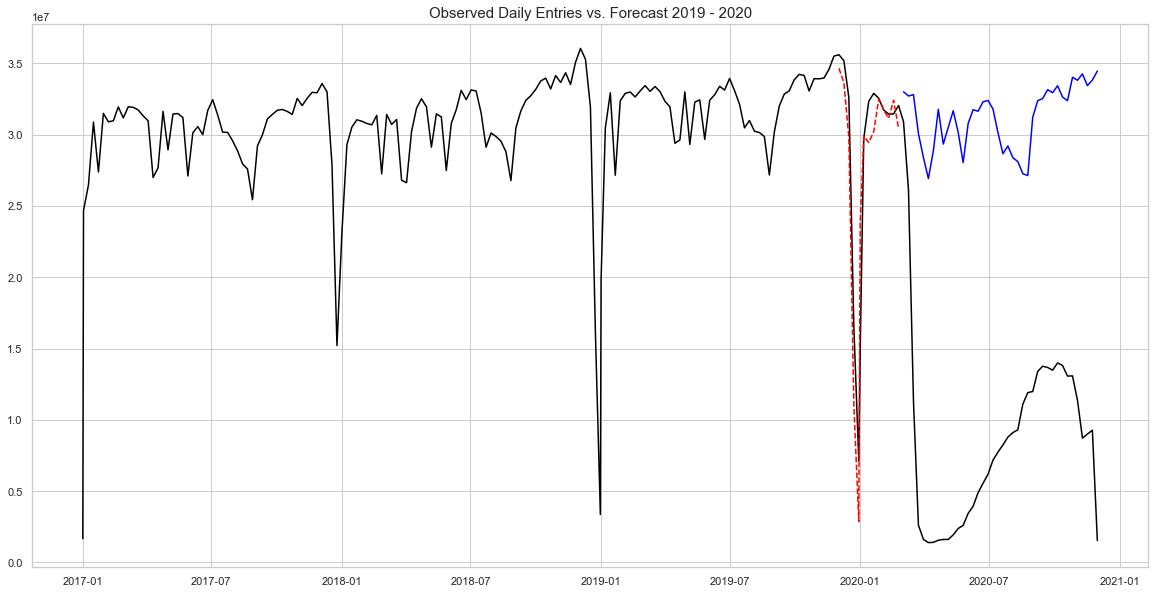

In [98]:
df = rail_ols_msoa
df2 = df_test
df3 = df_test

df = df[df['week_beg']>='01/01/2017'].groupby(['week_beg'])['origin_trips'].agg('sum')
df = pd.DataFrame(df)
df = df.reset_index()

df2 = df2[(df2['week_beg']>='12/01/2019')&(df2['week_beg']<='02/29/2020')].groupby(['week_beg'])['estimate'].agg('sum')
df2 = pd.DataFrame(df2)
df2 = df2.reset_index()

df3 = df3[df3['week_beg']>='02/29/2020'].groupby(['week_beg'])['estimate'].agg('sum')
df3 = pd.DataFrame(df3)
df3 = df3.reset_index()


fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=False, sharey=False)
plt.plot(df.week_beg, df.origin_trips, color = 'black')
plt.plot(df2.week_beg, df2.estimate, color = 'red', ls='--')
plt.plot(df3.week_beg, df3.estimate, color = 'blue')
ax.set_title('Observed Daily Entries vs. Forecast 2019 - 2020', fontsize = 15)

(0.0, 200.0)

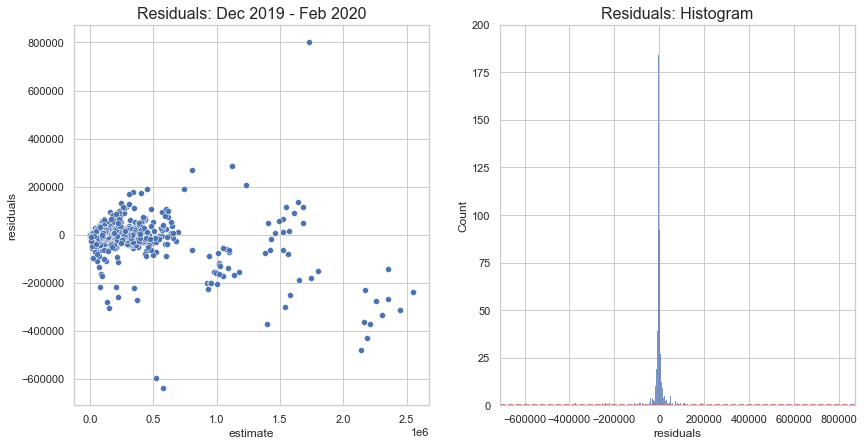

In [99]:
# Plotting of residuals against existing model, not forecasted values.
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)

df = df_test
df = df[(df['week_beg']>='12/01/2019')&(df['week_beg']<='02/29/2020')]

sns.scatterplot(x = "estimate", y = "residuals", data = df, ax=ax[0])
plt.axhline(y=0, color='r', ls='--')

sns.histplot(data=df, x='residuals')
ax[0].set_title('Residuals: Dec 2019 - Feb 2020', fontsize = 16)
ax[1].set_title('Residuals: Histogram', fontsize = 16)
ax[1].set_ylim(0,200)
#ax[1].set_xlim(-500000,500000)

In [110]:
# Check for forecast accuracy
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Durbin Watson Statistic for serial correlation of errors of model
# https://www.machinelearningplus.com/vector-autoregression-examples-python/
# Calculate r-squared
# https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python

df = df_test
df = df[(df['week_beg']>='12/01/2019')&(df['week_beg']<='02/29/2020')]

correlation_matrix = np.corrcoef(df['estimate'], df['origin_trips'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2


res = df['residuals']**2
RMSE = round(sqrt(res.mean()), 3)
MAPE = np.mean(np.abs(df['residuals'])/np.abs(df['origin_trips']))
out = durbin_watson(df['residuals'])

d = {'Forecast Test':['R-Squared','RMSE', 'MAPE', 'Durbin-Watson'], 'Value':[r_squared, RMSE, MAPE, out]}
df = pd.DataFrame(d)
df

,Forecast Test,Value
0,R-Squared,0.98
1,RMSE,"30,249.96"
2,MAPE,1.45
3,Durbin-Watson,1.15


### Recovery Rate Data Frame

In [152]:
rail_msoaest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10227 entries, 257 to 121943
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   year                   10227 non-null  int64         
 1   week                   10227 non-null  int64         
 2   week_beg               10227 non-null  datetime64[ns]
 3   msoa_code              10227 non-null  object        
 4   msoa_name              10227 non-null  object        
 5   geometry               10227 non-null  geometry      
 6   number_tubestations    10227 non-null  float64       
 7   origin_trips           10227 non-null  float64       
 8   destination_trips      10227 non-null  float64       
 9   log_origin_trips       10227 non-null  float64       
 10  log_destination_trips  10227 non-null  float64       
 11  estimate_log_origin    10227 non-null  float64       
 12  estimate_origin        10227 non-null  float64   

In [153]:
# Calculate the percent difference between actual trips and predicted trips
df = rail_msoaest
df = df[(df['week_beg']>='03/24/2020')&(df['week_beg']<='09/14/2020')]

# Calculate Origin Trips by Estimate2
df['delta'] = df['origin_trips']-df['estimate_origin']
df['pct_diff'] = df['origin_trips']/df['estimate_origin']
df['log_pctdiff'] = np.log(df['pct_diff'])
#df = df.merge(days_map, left_on = 'week_beg', right_on = 'date')

rail_msoaest = df

In [154]:
# Calculate weeks from the beginning of the lockdown, this is important for the slope estimates (cannot be against a datetime object)

df = rail_msoaest
df = df[(df['week_beg']>='03/24/2020')&(df['week_beg']<='09/14/2020')]
df = df['week_beg'].unique()
df = pd.DataFrame(df)
df.rename(columns = {0:'week_beg'}, inplace = True)

df['weeks'] = 0
df = df.sort_values(by=['week_beg'])

# For loop to calculate number of days in the analysis
for j in range(0, len(df)):
    if (j==0):
        df.iloc[j, len(df.columns)-1] = 0
    else:
        df.iloc[j, len(df.columns)-1] = df.iloc[j-1, len(df.columns)-1] + 1

weeks_map = df
#weeks_map

Text(0.5, 1.0, '% Actual v. Predicted All MSOAs')

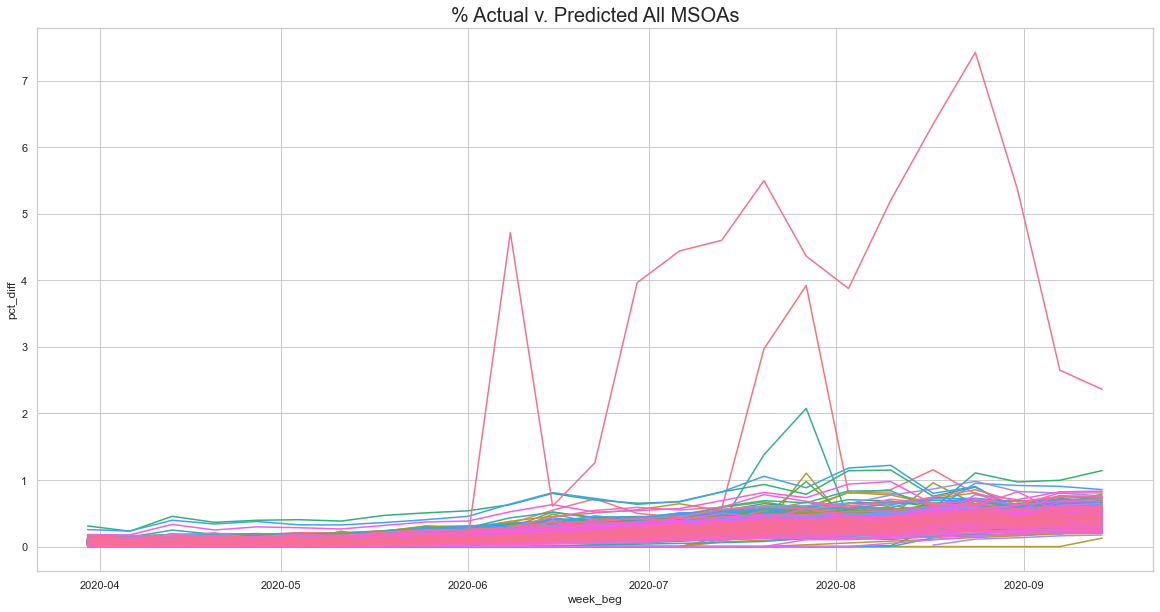

In [155]:
df = rail_msoaest

fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=False, sharey=False)
p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='msoa_name', legend = False)#, ax=ax[0])
p.set_title("% Actual v. Predicted All MSOAs", fontsize = 20)

In [156]:
#df = rail_msoaest[(rail_msoaest['msoa_name']!='Enfield 033')&(rail_msoaest['msoa_name']!='Barking and Dagenham 018')]

#fig, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=False, sharey=False)
#p = sns.lineplot(x='week_beg', y='pct_diff', data = df, hue='msoa_name', legend = False)#, ax=ax[0])
#p.set_title("% Actual v. Forecast All Local Authorities", fontsize = 20)

In [157]:
# Code references:
# how to extract trend from decomposed model: https://mlforanalytics.com/2020/05/29/decomposing-time-series-financial-analytics/

pd.options.display.float_format = '{:,.4f}'.format

df = rail_msoaest
df = df.groupby(['msoa_name', 'msoa_code'])['week_beg'].count()
df = pd.DataFrame(df)
df = df.reset_index()
df = df[df['week_beg']>24]
msoauth = df[['msoa_name']].drop_duplicates()
msoauth = np.array(msoauth)
msoauthcode = df[['msoa_code']].drop_duplicates()
msoauthcode = np.array(msoauthcode)
msoauth


df_slope = []
df_slope = pd.DataFrame(df_slope)
df_slope['msoa_name'] = 0
df_slope['msoa_code'] = 0
df_slope['slope'] = 0
df_slope['pct_change'] = 0
df_slope['slope2'] = 0
df_decompose = []

# We have an issue where some msoaauth stopped having service in the summer. could be MSOAs with national rail
# stations that were not used until the fall. we're going to drop these as it doesn't make sense to 
# impute the data.

for i in range(0,len(msoauth)):
    # Create a dataframe for each local authority
    df = rail_msoaest[rail_msoaest['msoa_name']==msoauth[i].item()]
    df = df[['week_beg', 'pct_diff']]
    df = df.set_index('week_beg')
    # Decompose the trend of origin trips
    #decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', extrapolate_trend = 'freq')
    decomposition = sm.tsa.seasonal_decompose(df, model = 'additive', period = 4)#int(len(df)/2))
    df_trend = pd.DataFrame(decomposition.trend[2:23]) ## This 2-23 is critical -- range without NaNs.
    df_trend = df_trend.reset_index()
    df_trend = df_trend.merge(weeks_map, how = 'left', left_on = 'week_beg', right_on = 'week_beg')
    # Create a dataframe of the trend
    # Calculate the slope of the trend
    trend = np.array(df_trend['trend'])
    weeks = np.array(df_trend['weeks'])
    slope,intercept = np.polyfit(weeks, trend, 1)
    # Store the local authority name and slope in a dataframe, total rows should be 33
    df_slope.loc[i,'msoa_name'] = msoauth[i].item()
    df_slope.loc[i,'msoa_code'] = msoauthcode[i].item()
    df_slope.loc[i,'slope'] = slope
    pct_change = ((df_trend.iloc[len(df_trend)-1,1] - df_trend.iloc[0,1])/df_trend.iloc[0,1])
    df_slope.loc[i,'pct_change'] = pct_change
    df_slope.loc[i,'slope2'] = pct_change/(len(df_trend)-1)

#df_slope
slope_msoa = df_slope
#slope_msoa

In [158]:
# Get geometry back, include Local Authority columns.
df = slope_msoa
df = df.merge(msoas, left_on = ['msoa_code'], right_on = ['MSOA11CD'])
df = gpd.GeoDataFrame(df, crs = 'epsg:27700')
df = df.rename({'LAD11NM':'la_name', 'LAD11CD':'la_code'}, axis=1)
df = df[['msoa_name', 'msoa_code', 'slope', 'la_name', 'la_code', 'geometry']]

slope_msoa = df

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\geopandas\plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


Text(0.5, 0.98, 'Slope of Percent Difference from 2020 Predicted Trips')

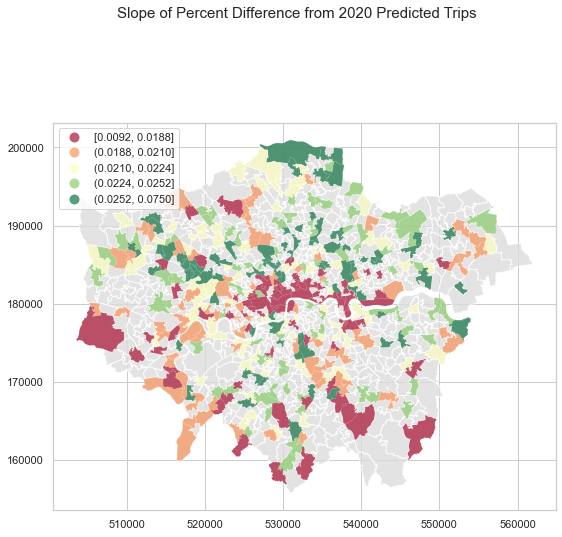

In [159]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
# We expect to see Central London has the smallest slope -- least likely these areas will have travel demand due to WFH.


f, ax = plt.subplots(1, figsize=(9, 9))

df = slope_msoa

plotmsoa = msoas.plot(axes=ax,alpha=0.8,color='gainsboro')
plotslope = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax
                      )
                                                                        

f.suptitle('Slope of Percent Difference from 2020 Predicted Trips', fontsize=15)

#### Feature Creation

In [160]:
# Reduce jobs data to relevant columns, estimate percentage of homeworking of total working population
# Jobs Data: 
# Homeworking % Data:

df = jobs

df = df.rename({'geography code':'msoa_code',
'geography': 'msoa_name',                
'Occupation: All categories: Occupation; Industry: All categories: Industry; measures: Value': 'all_occupations',
'Occupation: 1. Managers, directors and senior officials; Industry: All categories: Industry; measures: Value':'managers',
'Occupation: 2. Professional occupations; Industry: All categories: Industry; measures: Value':'professional_occupations',
'Occupation: 3. Associate professional and technical occupations; Industry: All categories: Industry; measures: Value':'associate_professional',
'Occupation: 4. Administrative and secretarial occupations; Industry: All categories: Industry; measures: Value':'administrative',
'Occupation: 5. Skilled trades occupations; Industry: All categories: Industry; measures: Value':'skilled_trade',
'Occupation: 6. Caring, leisure and other service occupations; Industry: All categories: Industry; measures: Value':'caring',
'Occupation: 7. Sales and customer service occupations; Industry: All categories: Industry; measures: Value':'sales',
'Occupation: 8. Process, plant and machine operatives; Industry: All categories: Industry; measures: Value':'plant_machine',
'Occupation: 9. Elementary occupations; Industry: All categories: Industry; measures: Value':'elementary_occupations'}, axis=1)

df = df[['msoa_code',
         'msoa_name',
         'managers',
         'professional_occupations',
         'associate_professional',
         'administrative',
         'skilled_trade',
         'caring',
         'sales',
         'plant_machine',
         'elementary_occupations',
         'all_occupations']]

df['managers_hw'] = df['managers']*.67349
df['professional_occupations_hw'] = df['professional_occupations']*.69582
df['associate_professional_hw'] = df['associate_professional']*.63719
df['administrative_hw'] = df['administrative']*.57242
df['skilled_trade_hw'] = df['skilled_trade']*.18519
df['caring_hw'] = df['caring']*.14894
df['sales_hw'] = df['sales']*.15914
df['plant_machine_hw'] = df['plant_machine']*.05439
df['elementary_occupations_hw'] = df['elementary_occupations']*0

df['all_occupations_hw'] = df['managers_hw']+df['professional_occupations_hw']+df['associate_professional_hw']+df['administrative_hw']+df['skilled_trade_hw']+df['caring_hw']+df['sales_hw']+df['plant_machine_hw']+df['elementary_occupations_hw']
df['hw_pct'] = df['all_occupations_hw']/df['all_occupations']
df = df[['msoa_code', 'msoa_name', 'hw_pct']]

jobs_hw = df
#jobs_hw.head()

In [161]:
# Get Covid rates for MSOAs in September, pull the maximum date available by end-September
# These rolling rates are likely only over 7 days, ideally, we want data showing number of cases by MSOA and calculate our own rate

df = covid_msoa
df['date'] = pd.to_datetime(df['date'])
df = df[df['date']<='9/30/2020']
df = df.groupby(['areaCode', 'areaName']).agg({'date':'max'})
df = pd.DataFrame(df)
df = df.reset_index()
df = df.merge(covid_msoa, left_on = ['areaCode', 'areaName', 'date'], right_on = ['areaCode', 'areaName', 'date'])
df = df.rename({'areaCode':'msoa_code',
                'areaName':'msoa_name',
                'newCasesBySpecimenDateRollingRate':'covidcases_rolling'}, axis = 1)

df = df[['msoa_code', 'date', 'covidcases_rolling']]
#df
covid_msoa_sep = df

In [162]:
# Covid Deaths by MSOA, monthly. This will capture data till end of September versus mid-September. 

coviddeaths = pd.read_csv('coviddeaths_MarNov.csv')
coviddeaths['coviddeaths_marsep'] = coviddeaths['March'] + coviddeaths['April'] + coviddeaths['May'] + coviddeaths['June'] + coviddeaths['July'] + coviddeaths['August'] + coviddeaths['September']

#coviddeaths.head()

In [163]:
# Cycling data, load in MSOAs by Hectare to normalise the metres of cycle paths versus area of MSOA. 
msoa_area = pd.read_csv('SAM_MSOA/SAM_MSOA_DEC_2011_EW.csv')

clt_msoas_dropgeo = clt_msoas[['msoa11cd', 'length']]
clt_msoas_dropgeo = clt_msoas_dropgeo.merge(msoa_area, left_on = 'msoa11cd', right_on = 'MSOA11CD')
clt_msoas_dropgeo['cyclelength_perhect'] = clt_msoas_dropgeo['length']/clt_msoas_dropgeo['AREAEHECT']

#clt_msoas_dropgeo.head()

In [164]:
# Count the following locations
# 1. category name = Bus Transport, classname = Bus Stops
# 2. category name = 'Public Transport, Stations and Infrastructure', may be collinear with number_tubestations
# 3. category name = Primary, Secondary and Tertiary Education
# 4. retail maybe?

df = poi_msoas
df_poi = poi_msoas[['msoa11cd']].drop_duplicates()

df_education = df[df['categoryname']=='Primary, Secondary and Tertiary Education'].groupby(['msoa11cd']).agg({'categoryname':'count'}).reset_index()
df_education = df_education.rename({'categoryname':'number_education'}, axis = 1)

df_busstops = df[(df['categoryname']=='Bus Transport')&(df['classname']=='Bus Stops')].groupby(['msoa11cd']).agg({'categoryname':'count'}).reset_index()
df_busstops = df_busstops.rename({'categoryname':'number_busstops'}, axis = 1)

df_pubtrans = df[df['categoryname']=='Public Transport, Stations and Infrastructure'].groupby(['msoa11cd']).agg({'categoryname':'count'}).reset_index()
df_pubtrans = df_pubtrans.rename({'categoryname':'number_pubtrans'}, axis = 1)

df_poi = df_poi.merge(df_education, how = 'left', left_on = 'msoa11cd', right_on = 'msoa11cd')
df_poi = df_poi.merge(df_busstops, how = 'left', left_on = 'msoa11cd', right_on = 'msoa11cd')
df_poi = df_poi.merge(df_pubtrans, how = 'left', left_on = 'msoa11cd', right_on = 'msoa11cd')

#df_poi.head()

In [165]:
# Loading in income data to see if this produces a stronger relationship versus IMD. 
income = pd.read_excel('ons-model-based-income-estimates-msoa-1.xls', sheet_name = '2015-16 (annual income)')

#income.head()
#income.info()

In [166]:
# Add in IMD, Count of Tube Stations, Homeworking %, Covid Cases

df = slope_msoa
df2 = rail_msoaest

# IMD
df = df.merge(imd_msoa, left_on = 'msoa_code', right_on = 'MSOAC')

# Tube Stations, using tube stations that were operational in 2020.
df2 = df2.groupby('msoa_code').agg({'number_tubestations':'mean', 
                                   'origin_trips':'sum',
                                   'destination_trips': 'sum'})
df = df.merge(df2, left_on = ['msoa_code'], right_on = ['msoa_code'])

# Homeworking %
df = df.merge(jobs_hw, left_on = ['msoa_code', 'msoa_name'], right_on = ['msoa_code', 'msoa_name'])

# Covid Cases
df = df.merge(coviddeaths, left_on = 'msoa_code', right_on = 'MSOA code')

# Cycle metres by MSOA
df = df.merge(clt_msoas_dropgeo, left_on = 'msoa_code', right_on = 'msoa11cd')

# Income by MSOA
income_msoa = income[['MSOA code', 'Total annual income (£)']]
df = df.merge(income, left_on = 'msoa_code', right_on = 'MSOA code')

# POI: Education, Public Transport Infra
df = df.merge(df_poi, left_on = 'msoa_code', right_on = 'msoa11cd')



# log slope
df['log_slope'] = np.log(df['slope'])

df = df.rename({'IMD19 SCORE':'imd_score',
                'MSOARANK':'msoa_rank',
                'MSOADECILE':'msoa_decile',
                'MSOAQUINTILE':'msoa_quintile',
                'Total annual income (£)': 'total_income'}, axis=1)

df = df[['msoa_name',
         'msoa_code',
         'slope',
         'log_slope',
         'la_name',
         'la_code',
         'geometry',
         'origin_trips',
         'destination_trips',
         'imd_score',
         'msoa_rank',
         'msoa_decile',
         'msoa_quintile',
         'number_tubestations',
         'cyclelength_perhect',
         'hw_pct',
         'coviddeaths_marsep',
         'total_income',
         'number_education',
         'number_busstops',
         'number_pubtrans']]

slope_msoa = df
slope_msoa.head()

,msoa_name,msoa_code,slope,log_slope,la_name,la_code,geometry,origin_trips,destination_trips,imd_score,...,msoa_decile,msoa_quintile,number_tubestations,cyclelength_perhect,hw_pct,coviddeaths_marsep,total_income,number_education,number_busstops,number_pubtrans
0,Barking and Dagenham 010,E02000011,0.0174,-4.0531,Barking and Dagenham,E09000002,"POLYGON ((550244.137 185994.019, 550272.848 18...","258,064.0000","234,589.0000",25.7140,...,4,2,1.0057,37.7510,0.3465,13,43500,2.0000,13.0000,2.0000
1,Barking and Dagenham 011,E02000012,0.0214,-3.8439,Barking and Dagenham,E09000002,"POLYGON ((546381.423 185104.331, 546383.689 18...","201,407.0000","174,523.0000",20.6322,...,5,3,1.0000,60.0588,0.3848,8,50800,3.0000,13.0000,2.0000
2,Barking and Dagenham 012,E02000013,0.0231,-3.7694,Barking and Dagenham,E09000002,"POLYGON ((547033.585 185348.362, 547228.838 18...","280,313.0000","265,296.0000",36.0912,...,2,1,1.0000,87.9153,0.3079,3,39100,2.0000,13.0000,2.0000
3,Barking and Dagenham 013,E02000014,0.0221,-3.8136,Barking and Dagenham,E09000002,"POLYGON ((548804.000 185232.000, 548903.063 18...","499,010.0000","481,791.0000",36.5500,...,2,1,1.0000,51.9480,0.2953,6,38100,3.0000,17.0000,2.0000
4,Barking and Dagenham 015,E02000016,0.0239,-3.7345,Barking and Dagenham,E09000002,"MULTIPOLYGON (((543565.813 183951.906, 543527....","1,638,722.0000","1,580,880.0000",33.6611,...,2,1,1.0057,83.1422,0.3582,1,41400,6.0000,22.0000,4.0000


Text(0.5, 1.0, 'Logged Slope')

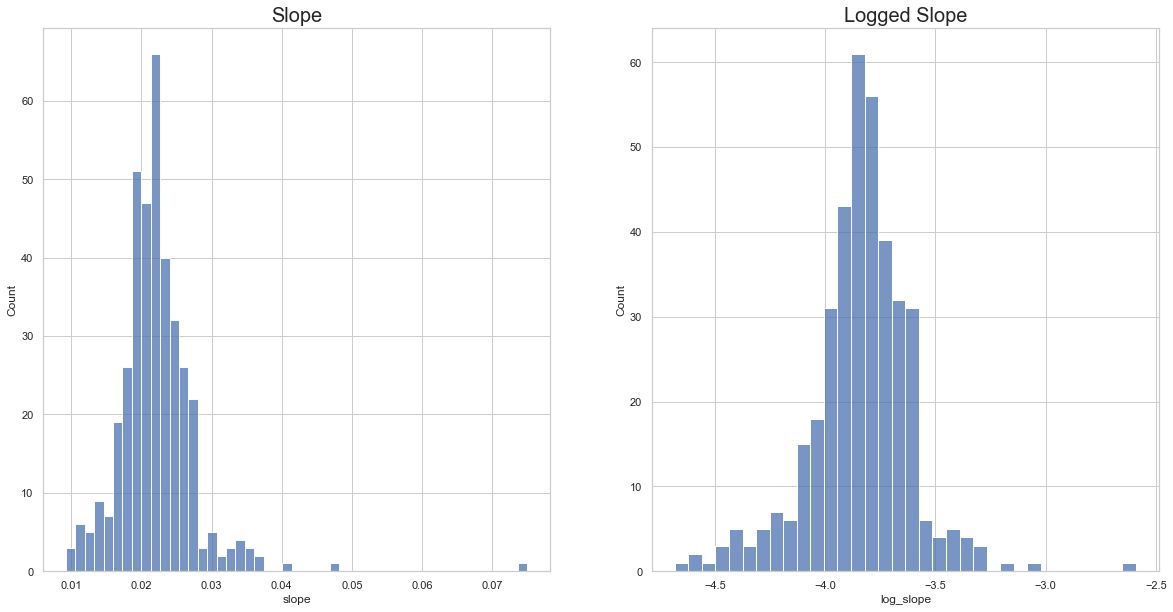

In [167]:
# Checking if logging changes the distribution, significantly. not so much, so analysis can stay with
# normal variable, it may instead be better to consider removing outliers.
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

df = slope_msoa

p = sns.histplot(data=df, x='slope', ax=ax[0])
q = sns.histplot(data=df, x='log_slope', ax=ax[1])
p.set_title("Slope", fontsize = 20)
q.set_title("Logged Slope", fontsize = 20)

In [171]:
slope_msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 384 entries, 0 to 383
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   msoa_name            384 non-null    object  
 1   msoa_code            384 non-null    object  
 2   slope                384 non-null    float64 
 3   log_slope            384 non-null    float64 
 4   la_name              384 non-null    object  
 5   la_code              384 non-null    object  
 6   geometry             384 non-null    geometry
 7   origin_trips         384 non-null    float64 
 8   destination_trips    384 non-null    float64 
 9   imd_score            384 non-null    float64 
 10  msoa_rank            384 non-null    int64   
 11  msoa_decile          384 non-null    int64   
 12  msoa_quintile        384 non-null    int64   
 13  number_tubestations  384 non-null    float64 
 14  cyclelength_perhect  384 non-null    float64 
 15  hw_pct         

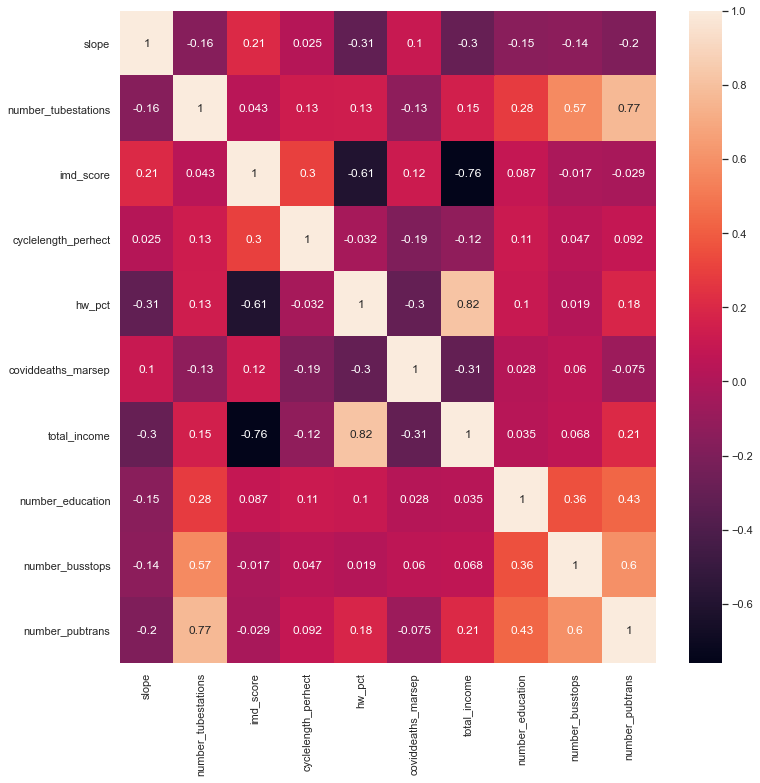

In [173]:
# Correlation Matrix to see which variables have the strongest association with slope

f, ax = plt.subplots(1, figsize=(12, 12))

df = slope_msoa#[slope_msoa['slope']<.006]

df_corr = df[['slope',
              'number_tubestations',
              'imd_score', 
              'cyclelength_perhect',
              'hw_pct',
              'coviddeaths_marsep',
              'total_income',
              'number_education',
              'number_busstops',
              'number_pubtrans']]

corrMatrix = df_corr.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Text(0.5, 1.0, 'Number of Public Transportation Infrastructure')

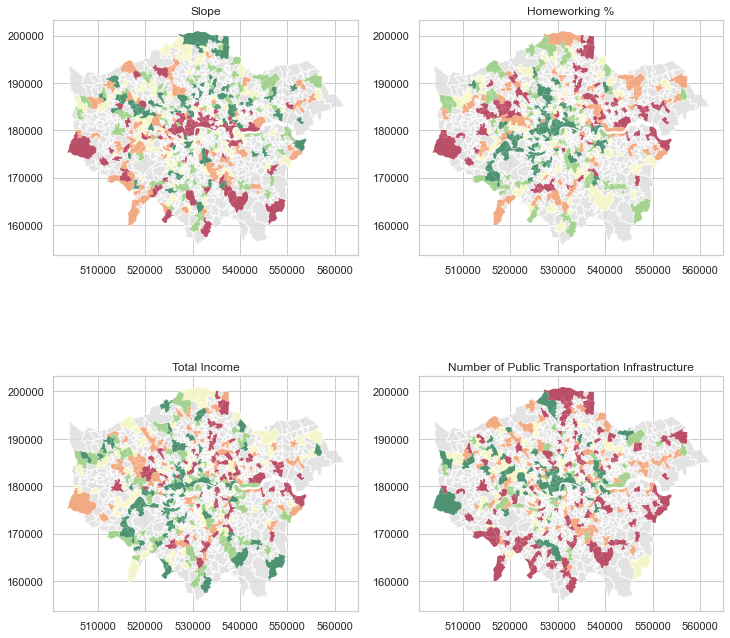

In [194]:
# Plotting variables selected to see spatial patterns. Based on the above: hw_pct, total_income, number_pubtrans have strongest
# correlation. May not look at imd_score or number_tube as this is likely collinear with other variables in dataset.

f, ax = plt.subplots(2,2, figsize=(12, 12))

df = slope_msoa



plotmsoa = msoas.plot(ax=ax[0,0],alpha=0.8,color='gainsboro')
plotslope = df.plot(column='slope', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       #legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[0,0]
                      )
ax[0,0].set_title('Slope')


plotmsoa = msoas.plot(ax=ax[0,1],alpha=0.8,color='gainsboro')
plothw = df.plot(column='hw_pct', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       #legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[0,1]
                      )
ax[0,1].set_title('Homeworking %')


plotmsoa = msoas.plot(ax=ax[1,0],alpha=0.8,color='gainsboro')
plotsincome = df.plot(column='total_income', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       #legend=True,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[1,0]
                      )
ax[1,0].set_title('Total Income')


plotmsoa = msoas.plot(ax=ax[1,1],alpha=0.8,color='gainsboro')
plotpubtrans = df.plot(column='number_pubtrans', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       #legend=False,
                       #legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax[1,1]
                      )
ax[1,1].set_title('Number of Public Transportation Infrastructure')                                                                        



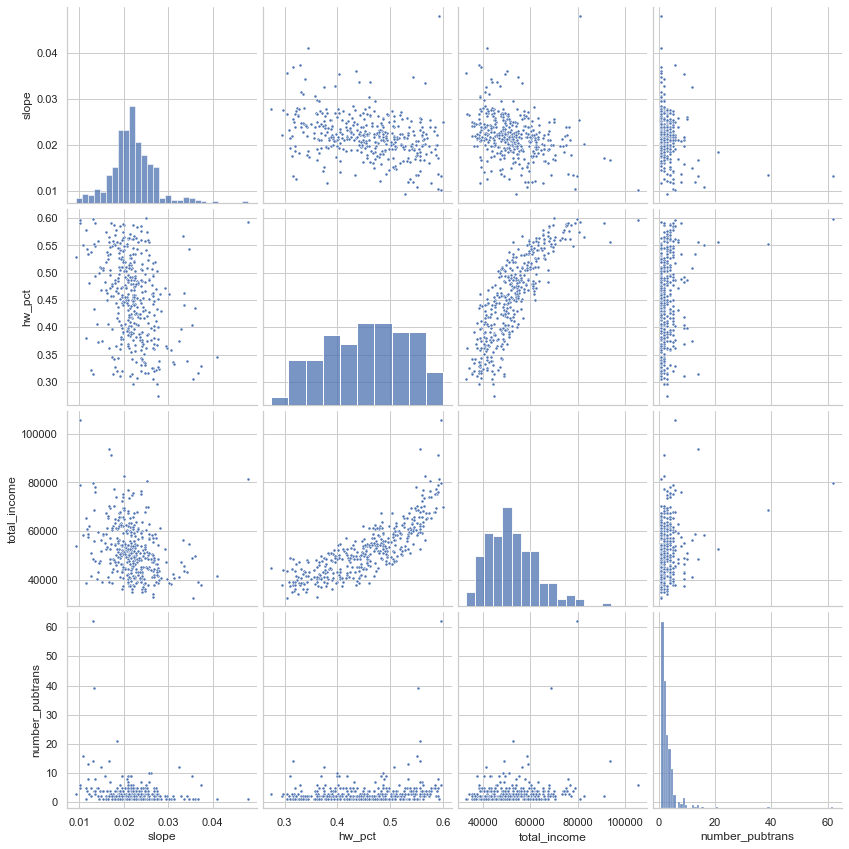

In [190]:
# Pairwise plot to see if there is a linear relationship

df = slope_msoa[slope_msoa['slope']<.06]
#df['log_length'] = np.log(df['length'])

cols_to_plot = ['slope',
                'hw_pct',
                'total_income',
                'number_pubtrans']

sns.pairplot(df, vars=cols_to_plot, markers=".", height=3)

In [ ]:
#df = slope_msoa[slope_msoa['slope']<1]

#sns.scatterplot(x = 'total_income', y = 'slope', data = df, hue = 'number_pubtrans')

In [192]:
# OLS model for all variables, none of the variables are significant in this case. Excluding potential outliers.

df = slope_msoa[slope_msoa['slope']<.06]

model = sm.formula.ols('slope ~ number_tubestations + imd_score + cyclelength_perhect + hw_pct + coviddeaths_marsep + total_income + number_education + number_busstops + number_pubtrans', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  slope   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     6.929
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           3.53e-09
Time:                        17:44:48   Log-Likelihood:                 1391.4
No. Observations:                 348   AIC:                            -2763.
Df Residuals:                     338   BIC:                            -2724.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0322      0.003     10.892      0.000       0.026       0.038
number_tubestations -9.727e-05      0.000     -0.243      0.808      -0.001       0.001
imd_score           -2.021e-05   4.26e-05     -0.475      0.635      -0.000    6.35e-05
cyclelength_perhect   6.28e-06   8.29e-06      0.758      0.449      -1e-05    2.26e-05
hw_pct                 -0.0108      0.006     -1.950      0.052      -0.022    9.58e-05
coviddeaths_marsep    2.67e-05   4.62e-05      0.578      0.564   -6.42e-05       0.000
total_income        -7.867e-08   4.93e-08     -1.596      0.112   -1.76e-07    1.83e-08
number_education       -0.0002   9.31e-05     -1.825      0.069      -0.000    1.32e-05
number_busstops     -1.898e-05    2.2e-05     -0.863      0.389   -6.22e-05    2.43e-05
number_pubtrans     -5.959e-05    9.4e-05     -0.634      0.527      -0.000       0.000
==============================================================================
Omnibus:                      111.717   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              597.098
Skew:                           1.238   Prob(JB):                    2.20e-130
Kurtosis:                       8.920   Cond. No.                     1.24e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
# OLS model for the ones we think are important, homeworking percent and public transport POIs are significant
# Excluding potential outliers (slope > 0.06)

df = slope_msoa[slope_msoa['slope']<.06]

model = sm.formula.ols('slope ~ hw_pct + total_income + number_pubtrans', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  slope   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     19.98
Date:                Fri, 16 Jul 2021   Prob (F-statistic):           5.45e-12
Time:                        17:43:13   Log-Likelihood:                 1433.7
No. Observations:                 359   AIC:                            -2859.
Df Residuals:                     355   BIC:                            -2844.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0311      0.001     22.070      0.000       0.028       0.034
hw_pct             -0.0122      0.005     -2.316      0.021      -0.023      -0.002
total_income    -6.025e-08   3.78e-08     -1.595      0.112   -1.35e-07    1.41e-08
number_pubtrans    -0.0002   5.45e-05     -3.084      0.002      -0.000   -6.09e-05
==============================================================================
Omnibus:                      103.057   Durbin-Watson:                   1.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.864
Skew:                           1.086   Prob(JB):                    1.62e-122
Kurtosis:                       8.725   Cond. No.                     1.21e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [195]:
#df = slope_msoa[slope_msoa['slope']<.006]

predictions = model.get_prediction(df)
predictions_summary_frame = predictions.summary_frame()
    

# for some reason, we need to specify the rows as the values are being inserted randomly otherwise 
# but, the errors indicate python does not like this.
df['estimate'] = predictions_summary_frame['mean']
df['residuals'] = df['estimate'] - df['slope']


Text(0.5, 1.0, 'Residuals: Histogram')

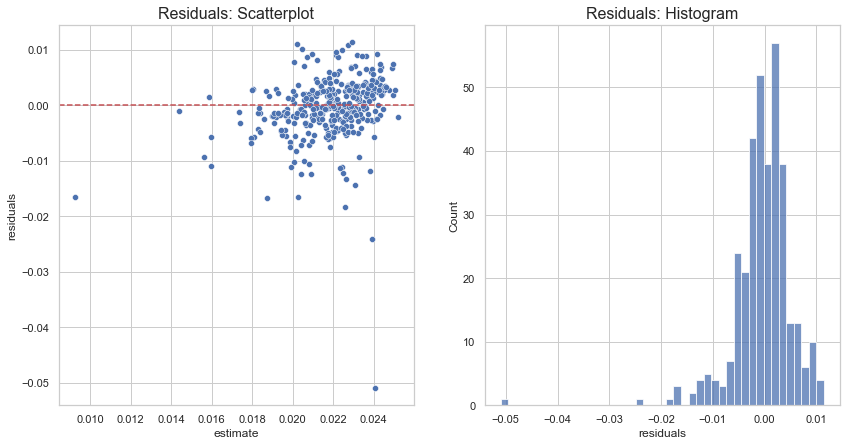

In [197]:
# Plotting of residuals against existing model, not forecasted values.
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)


sns.scatterplot(x = "estimate", y = "residuals", data = df, ax=ax[0])#, hue = 'number_pubtrans')
ax[0].axhline(y=0, color='r', ls='--')

sns.histplot(data=df, x='residuals')
ax[0].set_title('Residuals: Scatterplot', fontsize = 16)
ax[1].set_title('Residuals: Histogram', fontsize = 16)
#ax[1].set_ylim(0,200)

C:\Users\TBD\.conda\envs\urbsim\lib\site-packages\geopandas\plotting.py:568: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


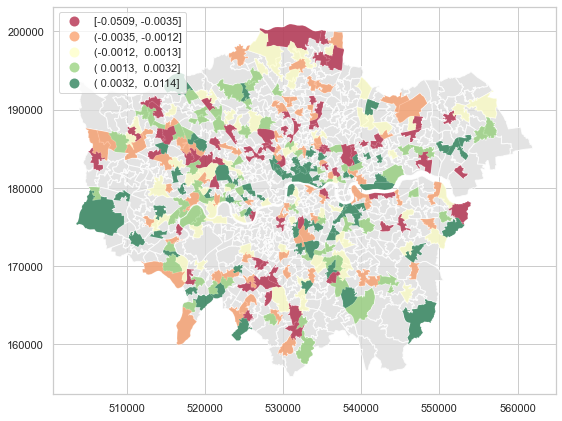

In [198]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
f, ax = plt.subplots(1, figsize=(9, 9))


plotmsoa = msoas.plot(axes=ax,alpha=0.8,color='gainsboro')
plotdf = df.plot(column='residuals', 
                       cmap='RdYlGn', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.65, 
                       legend=True,
                       legend_kwds={'fmt':'{:.4f}',"loc": 2},
                       ax=ax
                      )

In [ ]:
# Data you do not have:

# Road Infrastructure
# Vehicle Ownership

In [199]:
# Save as Shape File

slope_msoa.to_file('output_data/slope_msoa.shp')